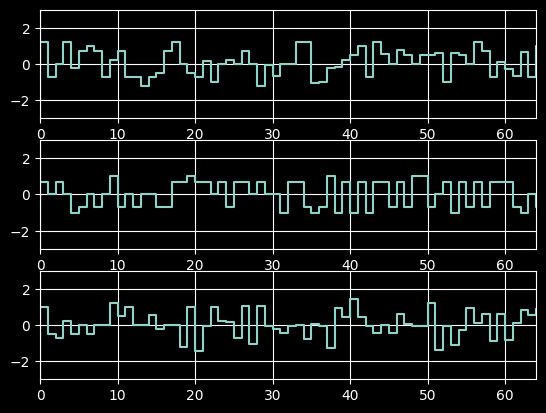

In [2]:
# plot data from ofdm dataset
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import matplotlib.pyplot as plt
from comm.OFDM import OFDM

BASE = '/Users/gtosun/Documents/vsc_workspace/ofdm-amc/data/data_lib'
plt.style.use(style='dark_background')

xpaths, ypaths = [], [],
for root, _, files in os.walk(BASE):
    for file in files:
        if file == 'x.npy': xpaths.append(os.path.join(root, file))
        if file == 'y.npy': ypaths.append(os.path.join(root, file))

d = defaultdict(lambda: defaultdict(dict))
for xp, yp in zip(sorted(xpaths), sorted(ypaths)):

    tmp = xp.split('/')
    mod = tmp[9]
    m = tmp[10]
    size = tmp[11]

    d[f'{m}{mod}'][size]['x'] = np.load(xp)
    d[f'{m}{mod}'][size]['y'] = np.load(yp)

frame = d['4psk']['512point']['x'][:, :, 999]
windows = [256, 512, 1024]

filter_bank = [OFDM(n_carriers=n) for n in windows]
t_signals = [filter.demodulate(frame) for filter in filter_bank]
fig, axs  = plt.subplots(len(t_signals), 1)

for ax, t in zip(axs, t_signals):
    ax.step(range(len(t[0,:])), t[0,:])
    ax.set_xlim(left=0, right=64)
    ax.set_ylim(bottom=-3, top=3)
    ax.grid(True)


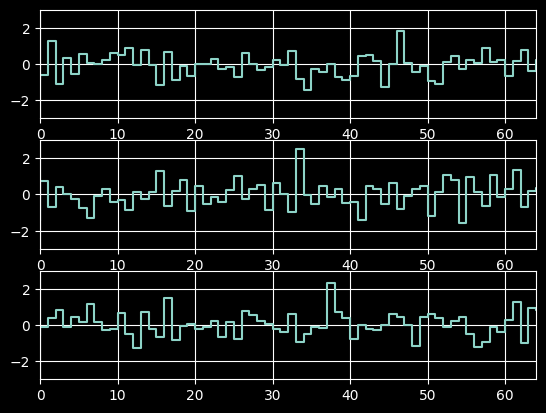

In [3]:
# try torch.stft and torch.istft here 
import torch

def transform(x, n: int):
    tmp = torch.stft(input=x, n_fft=n, hop_length=n, center=True, normalized=True, onesided=False, return_complex=True)
    tmp = torch.reshape(tmp, (1, tmp.numel()))
    return torch.row_stack((torch.real(tmp), torch.imag(tmp)))

complex_frame = torch.from_numpy( frame[0, :] + 1j * frame[1, :] )
u = [transform(complex_frame, n) for n in windows]

fig, axs  = plt.subplots(len(u), 1)
for ax, t in zip(axs, u):
    ax.step(range(len(t[1,:])), t[1,:])
    ax.set_xlim(left=0, right=64)
    ax.set_ylim(bottom=-3, top=3)
    ax.grid(True)

In [ ]:
# plot constellations from dataset 
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

BASE = '/Users/gtosun/Documents/vsc_workspace/modulation-classification/data/categorical/24db'
plt.style.use(style='dark_background')

xpaths, ypaths = [], [],
for root, _, files in os.walk(BASE):
    for file in files:
        if file == 'x.npy': xpaths.append(os.path.join(root, file))
        if file == 'y.npy': ypaths.append(os.path.join(root, file))

d = defaultdict(lambda: dict())
for xp, yp in zip(sorted(xpaths), sorted(ypaths)):

    tmp = xp.split('/')
    m = tmp[-2]
    mod = tmp[-3]

    d[f'{m}{mod}']['x'] = np.load(xp)
    d[f'{m}{mod}']['y'] = np.load(yp)

import matplotlib.pyplot as plt
plt.style.use(style='dark_background')
mods = ["2psk", "4psk", "4qam", "8psk", "16qam", "16psk", "64qam"]
label_dict = {i: mod for i, mod in enumerate(mods)}

ks = list(d.keys())
num_types = len(ks)

nrows = 2
ncols = 4

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)
for i in range(nrows):
    for j in range(ncols):

        idx = i * ncols + j
        if idx >= num_types:
            fig.delaxes(axs[i][j])
            break

        k = ks[idx]

        x = d[k]['x'][0, :, :]
        xi, xq = x[0, :], x[1, :]

        y = d[k]['y'][0]
        _, idx = torch.max(torch.squeeze(torch.Tensor(d[k]['y'][0])), 0)
    
        axs[i][j].set_title(label_dict[idx.item()])
        axs[i][j].scatter(xi, xq, marker='s', s=0.75, c='c')
        axs[i][j].set_xlim(left=-1.5, right=1.5)
        axs[i][j].set_ylim(bottom=-1.5, top=1.5)
        axs[i][j].set_aspect('equal')
        axs[i][j].margins(0)
        axs[i][j].grid(True)

fig.set_size_inches(w=ncols * 2, h=nrows * 2)
fig.suptitle('constellations')
fig.tight_layout()

In [1]:
import sys
import torch
import numpy as np
from model.AMCModel import AMCModel
from data.dataset.OFDMDataset import OFDMDataset, get_dataloaders
from torch.optim import Adam, RMSprop
import torch.nn as nn


LR = 0.0003
BATCH_SIZE = 1
SHUFFLE = True
EPOCHS = 1

dataset = OFDMDataset()
trainloader, testloader = get_dataloaders(dataset=dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

model = AMCModel()
model = model.train()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=LR)

n_total_steps = len(trainloader)
losses = []
predictions = []
for epoch in range(EPOCHS):
    model = model.train()
    for i, (x, y) in enumerate(trainloader):
        optimizer.zero_grad()
        scores = model(x)
        loss = criterion(scores, torch.squeeze(y))
        loss.backward()
        optimizer.step()

        predictions.append(torch.argmax(scores).item())
        losses.append(loss.item())

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{n_total_steps}], Loss: {np.mean(losses):.4f}')
            losses.clear()

    model = model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        for x, y in testloader: 
            scores = model.forward(x)
            predicted = torch.argmax(scores).item()
            labels = torch.argmax(torch.squeeze(y)).item()
            n_samples += y.size(0)
            n_correct += predicted == labels

        acc = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network on the test set: {acc} %')

/Users/gtosun/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/1], Step [100/7650], Loss: 1.1578
Epoch [1/1], Step [200/7650], Loss: 1.1031
Epoch [1/1], Step [300/7650], Loss: 1.0976
Epoch [1/1], Step [400/7650], Loss: 1.1112
Epoch [1/1], Step [500/7650], Loss: 1.1108
Epoch [1/1], Step [600/7650], Loss: 1.1002


[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument
[E thread_pool.cpp:113] Exception in thread pool task: mutex lock failed: Invalid argument


KeyboardInterrupt: 